In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


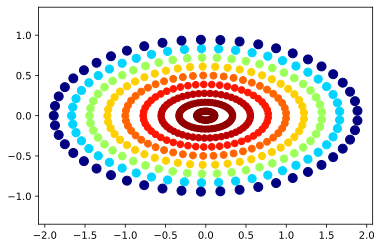

In [2]:
n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)
x_ = r_ * np.cos(t_) * 2.0 # = a 
y_ = r_ * np.sin(t_) * 1.0 # = b
F_ = np.sqrt(1 - np.square(r_))

plt.scatter(x_, y_, c=F_, cmap=plt.cm.jet, s=100*(1-F_*0.6))
plt.axis('equal')
plt.show()


In [3]:
dt = t[1] - t[0]
r_node = np.linspace(0., 1., int(n/5+1))
Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

r_, t_ = np.meshgrid(r, t)
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio.sum()

1.0

In [4]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10

r_mesh = r_.reshape(-1)
t_mesh = t_.reshape(-1)
ratio_mesh = ratio.reshape(-1)
x_mesh = r_mesh * np.cos(t_mesh)
y_mesh = r_mesh * np.sin(t_mesh)


In [5]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])


In [56]:
x_ball = xvw_ball[0:3]
v_ball = xvw_ball[3:6]
w_ball = xvw_ball[6:9]

Zeros = np.zeros(3)
vr = np.linalg.norm(v_ball)
x_square = np.square(x_mesh)
y_square = np.square(y_mesh)

dx      = np.zeros([2, 2])
k_      = dx.copy()
a_      = dx.copy()
b_      = dx.copy()
v_      = dx.copy()
F_norm  = dx.copy()

cos_sin   = np.zeros([2, 2, 2])
SP_r_inv  = cos_sin.copy()
R_Reduced = cos_sin.copy()

exyz    = np.zeros([2, 2, 3])
F_      = exyz.copy()
a_dir   = exyz.copy()
peak    = exyz.copy()

eta   = np.zeros([2, 3])
b_dir = eta.copy()
v_eta = eta.copy()

xyz2eta = np.zeros([2, 3, 3])

n_mesh = len(x_mesh)
F_mesh = np.zeros([2, 2, n_mesh])

p_mesh = np.zeros([2, 2, n_mesh, 3])
SP_v   = p_mesh.copy()
BL_v   = p_mesh.copy()
dv     = p_mesh.copy()
muT    = p_mesh.copy()

v_dir = np.zeros([2, 2, 3, n_mesh])
muF   = v_dir.copy()

for iSP, SP in enumerate(SP12):

    eta[iSP,:] = SP.to_eta2(x_ball)
    xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
    b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
    v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

    for i in range(2):
        cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
        if dx[iSP,i] > 0:
            SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
            R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
            k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
            v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
            F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
            F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

            a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])

            peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]

            p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
            
            R_hoge = R * 1.08
            print('peak')
            print(np.linalg.norm(x_ball - peak[iSP,i,:]))
            p_a = peak[iSP,i,:] + a_[iSP,i] * a_dir[iSP,i,:] - 0.5 * np.square(a_[iSP,i]) / R_hoge * exyz[iSP,i,:]
            dist_a = p_a - x_ball
            print('a')
            print(np.linalg.norm(dist_a))
            p_b = peak[iSP,i,:] + b_[iSP,i] * b_dir[iSP,:] - 0.5 * np.square(b_[iSP,i]) / R_hoge * exyz[iSP,i,:]
            dist_b = p_b - x_ball 
            print('b')
            print(np.linalg.norm(dist_b))
            
            
            print(R)
            print(1 / SP_r_inv[iSP,i,:])
            
            F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh

            SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
            BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
            dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
            v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
            muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
            muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)

Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6


peak
3.174017002477907
a
3.175423665710621
b
3.174057349277113
3.175
[26.75010881 -3.429     ]
peak
3.1740170032230273
a
3.1753918399115655
b
3.1740687598747575
3.175
[-33.096177  -3.429   ]


In [6]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -1e-2 * rpm * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R * np.sign(rpm)
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


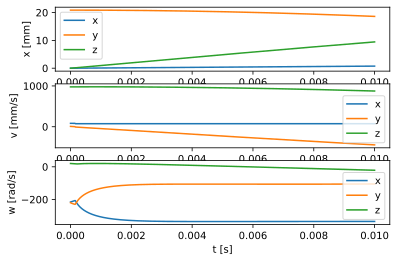

In [7]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vFmTI_ball, xvw_ball, t, args=(0,))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[0].set_ylabel('x [mm]')
ax[0].legend(['x', 'y', 'z'])

ax[1].plot(t[:], sol[:, 3:6])
ax[1].set_ylabel('v [mm/s]')
ax[1].legend(['x', 'y', 'z'])

ax[2].plot(t[:], sol[:, 6:9])
ax[2].set_ylabel('w [rad/s]')
ax[2].legend(['x', 'y', 'z'])
ax[2].set_xlabel('t [s]')

plt.show()


In [8]:
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit):
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax


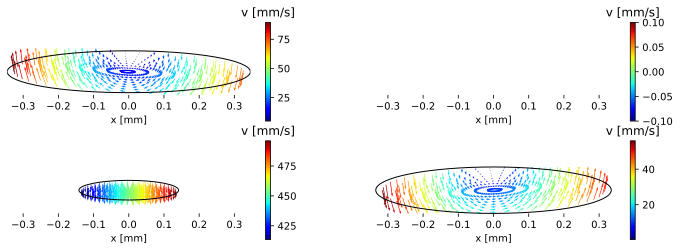

In [9]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [10]:
n_hoge = 21
x_hoge = np.linspace(-1, 1, n_hoge)
x_mesh, y_mesh = np.meshgrid(x_hoge, x_hoge)
x_mesh = x_mesh.reshape(-1)
y_mesh = y_mesh.reshape(-1)


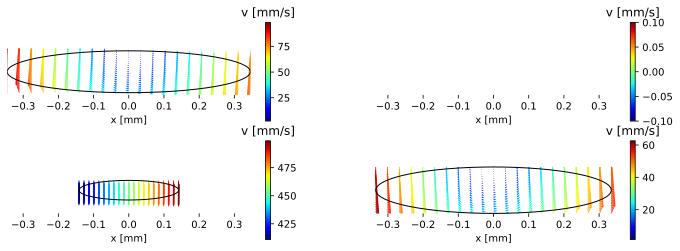

In [11]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


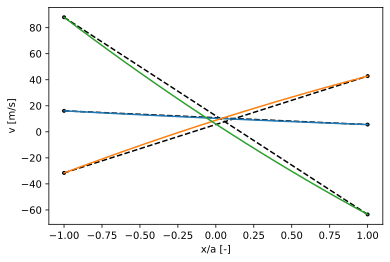

In [12]:
plt.plot(x_mesh[10*n_hoge:11*n_hoge:n_hoge-1], dv[0, 0, 10*n_hoge:11*n_hoge:n_hoge-1], 'k.--')
plt.plot(x_mesh[10*n_hoge:11*n_hoge:], dv[0, 0, 10*n_hoge:11*n_hoge:])
plt.xlabel('x/a [-]')
plt.ylabel('v [m/s]')
plt.show()


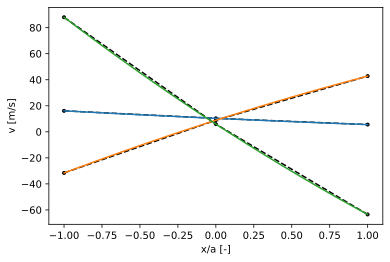

In [13]:
plt.plot(x_mesh[10*n_hoge:11*n_hoge:int(n_hoge/2)], dv[0, 0, 10*n_hoge:11*n_hoge:int(n_hoge/2)], 'k.--')
plt.plot(x_mesh[10*n_hoge:11*n_hoge:], dv[0, 0, 10*n_hoge:11*n_hoge:])
plt.xlabel('x/a [-]')
plt.ylabel('v [m/s]')
plt.show()


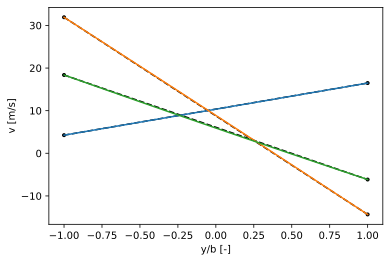

In [14]:
plt.plot(y_mesh[10::20*n_hoge], dv[0, 0, 10::20*n_hoge], 'k.--')
plt.plot(y_mesh[10::n_hoge], dv[0, 0, 10::n_hoge])
plt.xlabel('y/b [-]')
plt.ylabel('v [m/s]')
plt.show()


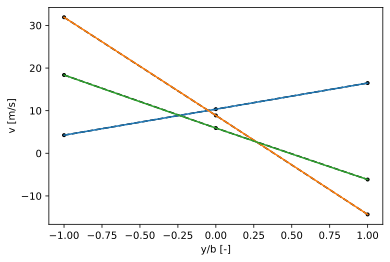

In [15]:
plt.plot(y_mesh[10::10*n_hoge], dv[0, 0, 10::10*n_hoge], 'k.--')
plt.plot(y_mesh[10::n_hoge], dv[0, 0, 10::n_hoge])
plt.xlabel('y/b [-]')
plt.ylabel('v [m/s]')
plt.show()


$$
\begin{align}
F &= F_{\text{up,right}} + F_{\text{up,left}} + F_{\text{down,left}} + F_{\text{down,right}} \\\\
\Delta u(s, t) &= u_0 + s u_a + t u_b \\\\
P(s, t) &= P_{\text{max}}\sqrt{1-s^2-t^2} \\\\
F_{\text{up,right}}&=\int_{t=0}^{1} \int_{s=0}^{\sqrt{1-t^2}} \frac{\Delta u(s, t)}{|\Delta u(s, t)|} \mu P(s, t) \cdot \text{d}s \text{d}t \\\\
&=\mu P_{\text{max}} \cdot \int_{t=0}^{1} \int_{s=0}^{\sqrt{1-t^2}} \frac{u_0 + s u_a + t u_b}{|u_0 + s u_a + t u_b|} \sqrt{1-s^2-t^2} \cdot \text{d}s \text{d}t \\\\
&= ... \\\\
&= \mu P_{\text{max}} \cdot f(u_0, u_a, u_b)\\\\
\end{align}
$$

Can I make it an identity?


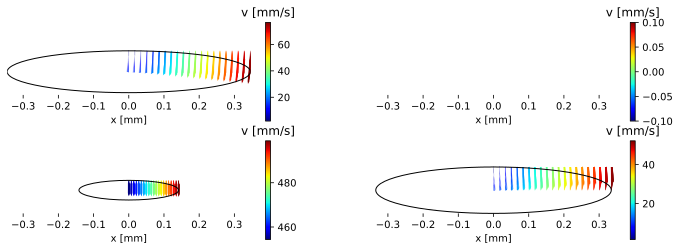

In [16]:
n_hoge = 21
x_hoge = np.linspace(0, 1, n_hoge)
x_mesh, y_mesh = np.meshgrid(x_hoge, x_hoge)
x_mesh = x_mesh.reshape(-1)
y_mesh = y_mesh.reshape(-1)
a_, b_, a_dir, b_dir, dv = vFmTI_ball(sol[-1, :], 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [17]:
P_mesh = 1 - x_mesh**2 - y_mesh**2
P_mesh[P_mesh<0]=0
np.sqrt(P_mesh)
P_mesh = P_mesh / P_mesh.sum()

u0 = dv[0,0,0]
ux = dv[0,0,n_hoge-1] - u0
uy = dv[0,0,n_hoge*(n_hoge-1)] - u0

u_mesh = u0 + Make_Matrix(x_mesh, ux) + Make_Matrix(y_mesh, uy)


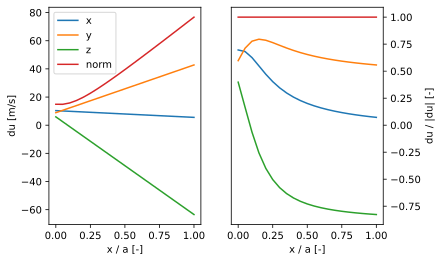

In [18]:
u_norm = np.sqrt(np.square(u_mesh).sum(1)).reshape([-1,1])
u_dir = u_mesh / u_norm

fig, ax = plt.subplots(1, 2)
ax[0].plot(x_mesh[:n_hoge], u_mesh[:n_hoge])
ax[0].plot(x_mesh[:n_hoge], u_norm[:n_hoge])
ax[0].set_xlabel('x / a [-]')
ax[0].set_ylabel('du [m/s]')
ax[0].legend(['x', 'y', 'z', 'norm'])
ax[1].plot(x_mesh[:n_hoge], u_dir[:n_hoge])
ax[1].plot(x_mesh[:n_hoge], np.ones(x_mesh[:n_hoge].shape))
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlabel('x / a [-]')
ax[1].set_ylabel('du / |du| [-]')
plt.show()


In [19]:
F = (u_dir * P_mesh.reshape([-1,1])).sum(0)
